# Bayesian Optimization (Regression Based Prediction)
#### Rick Gosalvez, Data Mining 2021

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as CK

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore")

### 1. Hidden Objective Function

In [3]:
def f(x):
    return np.sin(6 * x) + np.cos(4 * x) + x**2             # in radians 

### 2. Find min y and the corrisponding x* (x_star): reusable/iterable functions

#### GP Surrogate Model Function

In [4]:
def gp_sur(ini,n_next, x):
    """
      GP Surrogate function - repeat until converged (same min. point given)
      ini is initial condition list
      n_next (same as x_next or x*) is the next point added to ini after identified
      x is grid parameters
    """
    ini = np.append(ini, n_next)                            # add x_next
    y = f(ini).ravel()                                      # evaluate function for x values

    df = pd.DataFrame(ini,columns=['x_ini'])                # create df
    df['y_ini'] = y                                         # add y = f(x) values to df

    X = np.reshape(ini,(len(ini),1))                        # reshape 1D to 2D array 

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X, y)

    y_pred, sigma = gp.predict(x, return_std=True)          # y_pred = mu, return std deviation

    df = pd.DataFrame(x,columns=['x'])                      # create df 
    df['y_pred'] = y_pred
    df['sigma']  = sigma
    df['lcb']    = y_pred - 1.9600*sigma                    # add LCB calc to DF
    
    n_next = df[df['lcb'] == df['lcb'].min()]               # find min LCB
    print(n_next)
    
    n_next = n_next.iloc[0,0].round(decimals=2)             # get corrisponding x* (x_next)
    print(f'\nx_next (min. LCB value): {n_next}\n')
    
    plot_GP(X,x,y,y_pred,sigma)                             # plot GP w/ uncertainty for iteration
    
    return ini, n_next, y, X

#### Plot Function

In [5]:
def plot_GP(X,x,y,y_pred,sigma):
    polynomial_features = PolynomialFeatures(degree=5, include_bias=False)
    Xp = polynomial_features.fit_transform(X)
    Xt = polynomial_features.fit_transform(x)
    pr = LinearRegression()
    pr.fit(Xp, y)
    y_pred_1 = pr.predict(Xt)

    plt.figure(figsize=[15,8])
    plt.plot(x, f(x), 'r-', label=r'$f(x) = \sin(6x)+\cos(4x)+x^2$')
    plt.scatter(X.ravel(), y, label = 'Observations')
    plt.plot(x, y_pred, 'b-', label='Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc='b', ec='None', label='95% confidence interval')
    plt.plot(x,y_pred_1, 'k-', label='Polynomial')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(-15, 20)                      # y height and intervals
    plt.legend(loc='upper left')

### 3. Set Grid to 0.01 Increments and Show Minimum Point on Grid

In [6]:
x = np.atleast_2d(np.linspace(-4, 4, 801)).T             # returns number spaces evenly w.r.t interval (100 per 1 unit)

In [7]:
# find min. y point for grid
grid   = np.arange(-4, 4, 0.01).tolist()
x_star = list(map(lambda x: f(x),grid))
print(f'Min. Point on Grid: {min(x_star):.3f}')

Min. Point on Grid: -1.406


### 4. First Iteration: Step-by-step

#### Initial Condition (10 data points). Evaluate Function Value to Find Min y and Corresponding x*

In [8]:
ini   = np.array([-2.75, -2.11, 2.59, 3.77, 3.98, -2.74, -2.86, 2.29, -0.69, -3.48])
y     = f(ini).ravel()
start = len(ini)

df = pd.DataFrame(ini,columns=['x_ini'])
df['y_ini'] = y

df

,x_ini,y_ini
0,-2.75,8.278711
1,-2.11,3.805559
2,2.59,6.281635
3,3.77,12.815458
4,3.98,13.912950
5,-2.74,8.140419
6,-2.86,9.602496
7,2.29,5.201110
8,-0.69,0.388637
9,-3.48,11.429655


#### Reshape Xini from 1D to 2D

In [9]:
X = np.reshape(ini,(10,1))

### 5. Construct Surrogate Model

#### GP Surrogate Model

In [10]:
kernel = CK(1.0, (1e-3, 1e3)) * RBF(1.,(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, y)

y_pred, sigma = gp.predict(x, return_std=True)          # y_pred = mu, return std deviation

In [11]:
# y_predict & sigma for ever single x value on grid (lots!)
y_pred

array([ 9.12635453e+00,  9.24054354e+00,  9.35241611e+00,  9.46187898e+00,
        9.56884300e+00,  9.67322343e+00,  9.77494018e+00,  9.87391807e+00,
        9.97008704e+00,  1.00633824e+01,  1.01537450e+01,  1.02411216e+01,
        1.03254647e+01,  1.04067331e+01,  1.04848917e+01,  1.05599119e+01,
        1.06317716e+01,  1.07004552e+01,  1.07659537e+01,  1.08282650e+01,
        1.08873936e+01,  1.09433505e+01,  1.09961538e+01,  1.10458279e+01,
        1.10924038e+01,  1.11359191e+01,  1.11764176e+01,  1.12139494e+01,
        1.12485704e+01,  1.12803425e+01,  1.13093332e+01,  1.13356152e+01,
        1.13592663e+01,  1.13803693e+01,  1.13990111e+01,  1.14152831e+01,
        1.14292802e+01,  1.14411008e+01,  1.14508464e+01,  1.14586210e+01,
        1.14645308e+01,  1.14686838e+01,  1.14711892e+01,  1.14721571e+01,
        1.14716981e+01,  1.14699224e+01,  1.14669399e+01,  1.14628593e+01,
        1.14577878e+01,  1.14518305e+01,  1.14450901e+01,  1.14376663e+01,
        1.14296552e+01,  

#### 6.a Find Next Point by LCB Acquisistion Function (beta = 1.9600)

In [12]:
# use every single x and sigma value in grid to run Lower Confidence Bound (LCB) 
df = pd.DataFrame(x,columns=['x'])
df['y_pred'] = y_pred
df['sigma']  = sigma
df['lcb']    = y_pred - 1.9600*sigma
df

,x,y_pred,sigma,lcb
0,-4.00,9.126355,4.544546,0.219044
1,-3.99,9.240544,4.449617,0.519293
2,-3.98,9.352416,4.353424,0.819705
3,-3.97,9.461879,4.256037,1.120047
4,-3.96,9.568843,4.157532,1.420081
...,...,...,...,...
796,3.96,13.891937,0.070434,13.753887
797,3.97,13.904851,0.037029,13.832275
798,3.98,13.912950,0.000010,13.912931
799,3.99,13.916203,0.040606,13.836615


#### 6.b Find min. LCB value and corrisponding x*

In [13]:
df[df['lcb'] == df['lcb'].min()]

,x,y_pred,sigma,lcb
466,0.66,0.003382,7.37354,-14.448757


In [14]:
n_next = df[df['lcb'] == df['lcb'].min()]
print(n_next)
n_next = n_next.iloc[0,0].round(decimals=2)
print(f'\nx_next (min. LCB value): {n_next}')

        x    y_pred    sigma        lcb
466  0.66  0.003382  7.37354 -14.448757

x_next (min. LCB value): 0.66


### 8a. Plot GP with uncertaining for first iteration (10 > 11 data points)

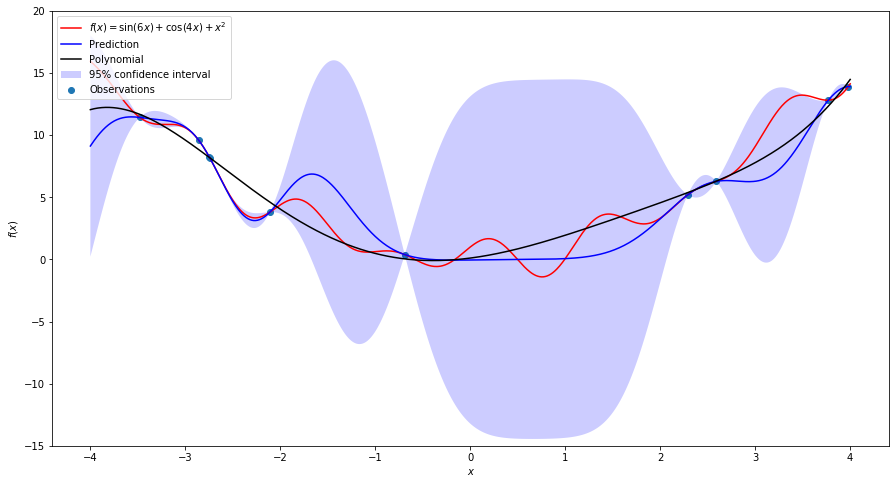

In [15]:
# Use LCB identified min value(s)[x_next, y_pred, sigma] to graph newest point
plot_GP(X,x,y,y_pred,sigma)

### 7 & 8b. Second Iteration: Add next point and evaluate the function value (11 > 12 data points)

        x    y_pred     sigma        lcb
535  1.35 -0.107882  6.097796 -12.059562

x_next (min. LCB value): 1.35



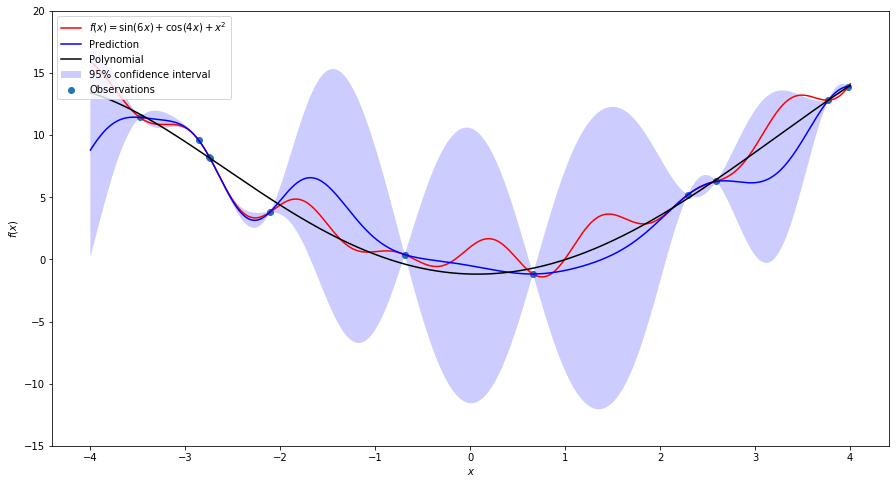

In [16]:
# Add n_next (same as x_next or x*) to initial condition list to evaluate next point for grid (x)
ini, n_next, y, X = gp_sur(ini,n_next, x)

### 8c. Add data and eval. GP function until gives the same minimum point (12 > nth iteration)

        x    y_pred     sigma        lcb
402  0.02 -1.184796  5.364704 -11.699616

x_next (min. LCB value): 0.02

        x    y_pred     sigma       lcb
282 -1.18  2.432463  4.523518 -6.433632

x_next (min. LCB value): -1.18

        x    y_pred     sigma       lcb
441  0.41 -0.904978  1.303636 -3.460105

x_next (min. LCB value): 0.41

        x    y_pred     sigma      lcb
493  0.93 -1.342724  0.851044 -3.01077

x_next (min. LCB value): 0.93

        x    y_pred     sigma       lcb
363 -0.37 -0.329539  0.946253 -2.184196

x_next (min. LCB value): -0.37

        x    y_pred    sigma       lcb
476  0.76 -1.393485  0.02724 -1.446875

x_next (min. LCB value): 0.76

        x    y_pred     sigma       lcb
476  0.76 -1.405655  0.000021 -1.405696

x_next (min. LCB value): 0.76



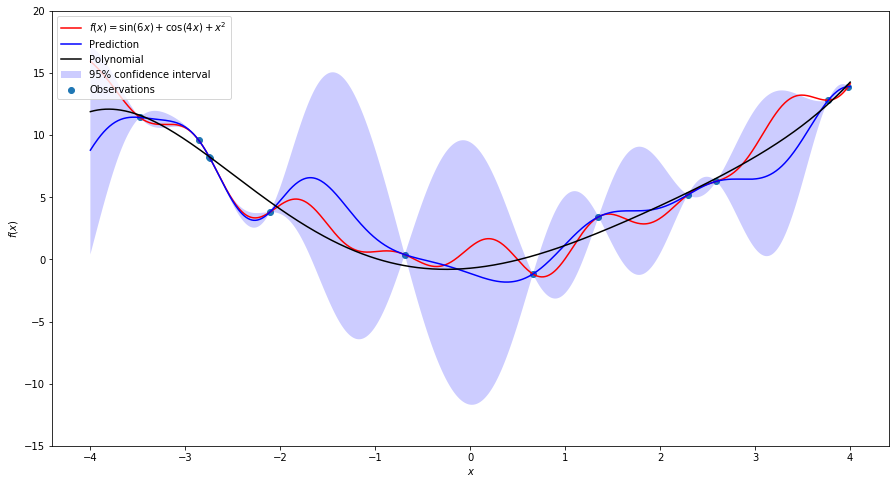

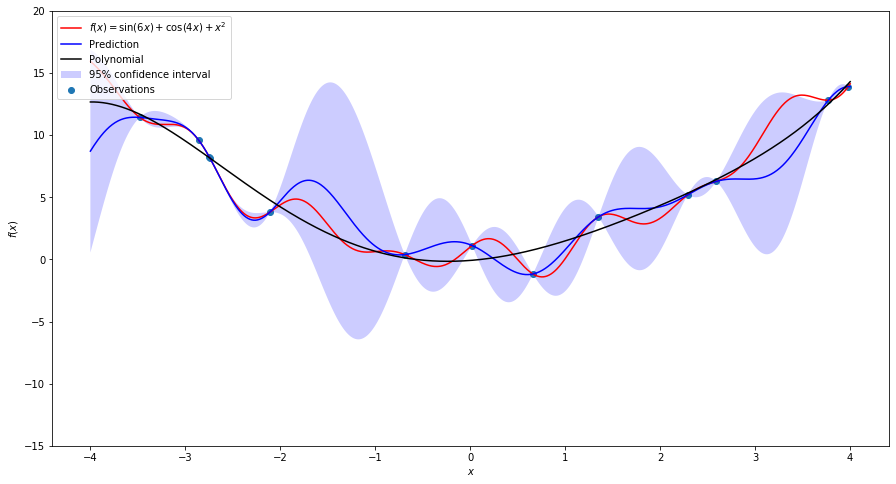

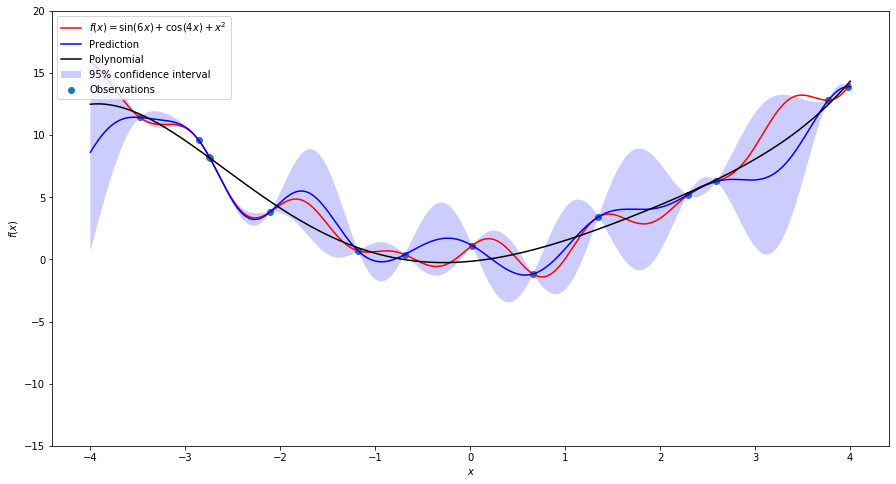

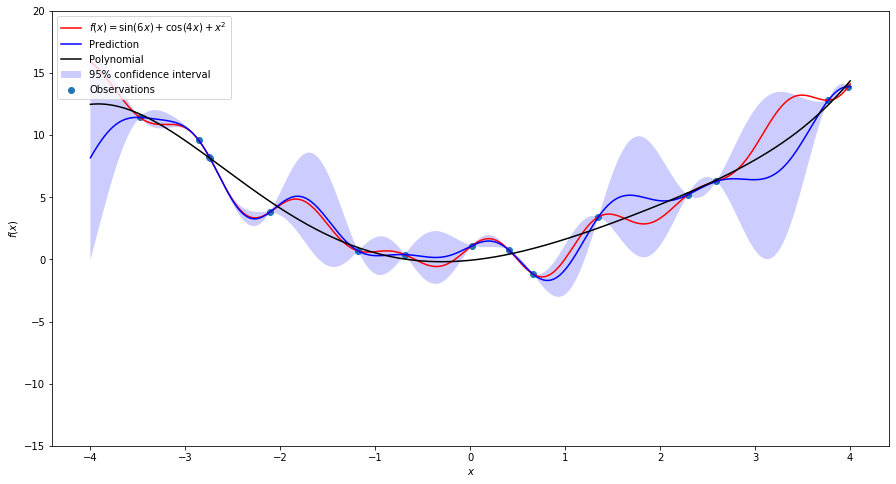

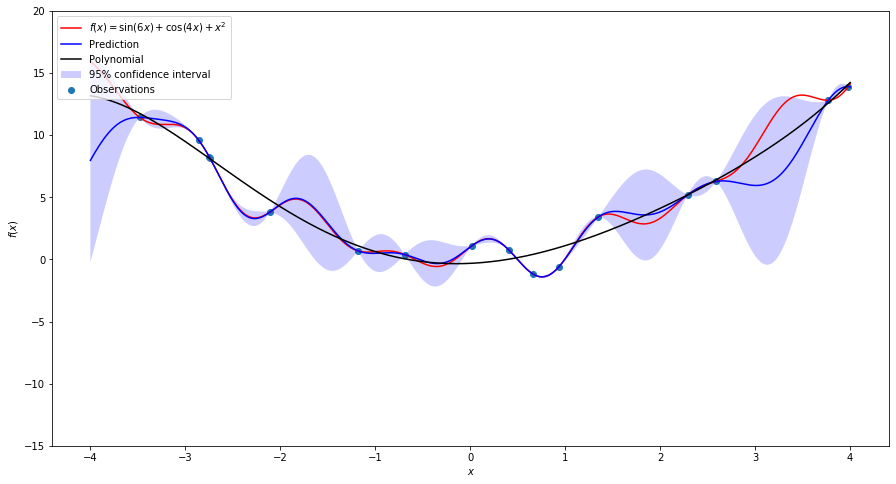

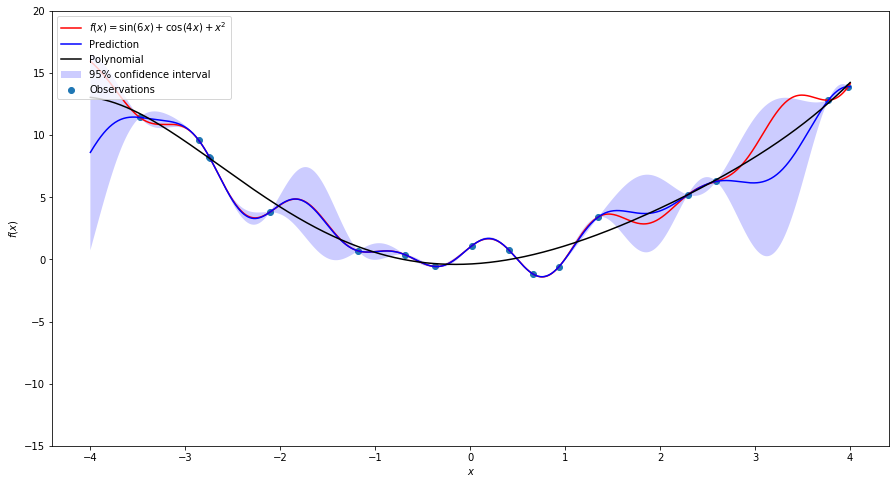

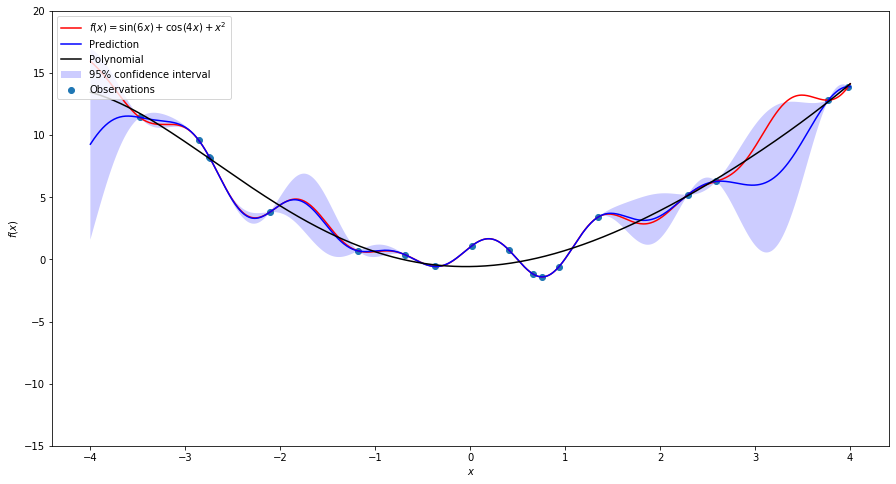

In [17]:
n = 7
for i in range(n):
    ini, n_next, y, X = gp_sur(ini,n_next, x)

### 8d. Show updated x data

In [18]:
ini = np.append(ini, n_next)
ini

array([-2.75, -2.11,  2.59,  3.77,  3.98, -2.74, -2.86,  2.29, -0.69,
       -3.48,  0.66,  1.35,  0.02, -1.18,  0.41,  0.93, -0.37,  0.76,
        0.76])

In [19]:
print(f'{len(ini)} total data points for convergence. Converged after {len(ini)-start}th iteration.')

19 total data points for convergence. Converged after 9th iteration.
